In [28]:
import os
import pickle
import numpy as np

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

In [26]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add
import cv2

In [9]:
BASE_DI=r'E:'
WORKING_DIR=r'F:\image_captioning'
#created a directroy
#os.makedirs(WORKING_DIR)

# Importing a vgg16 pre defined weights and apply it on all the images


## we dropped the last layer of activation function and stored the last layer as feature matrix for each image
## we get around 4096 values for each image

In [10]:
model=VGG16(weights='imagenet')
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
count=0
features={}
directory=os.path.join(BASE_DI,'Images')
print(directory)
for img_name in (os.listdir(directory)):
    img_path=directory+'/'+img_name
    image=cv2.imread(img_path)
    image=cv2.resize(image,(224,224))
    image=np.expand_dims(image,axis=0)
    image=img_to_array(image)
#     image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature
    print(count)
    count+=1


# checking if the gpu is working 

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12907969074647656573
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236245607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14357277853069142095
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [12]:
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Storing the features_matrix as it takes lot of time to preprocess each image 
# and run the model on each image every time
## so storing it as a dictionary with dic[image]=[feature array]

In [13]:
# # storing features in pickle
# pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))


In [14]:
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features=pickle.load(f)

# Creating a dictionary to store image: with their all captions:

In [15]:
with open(os.path.join(BASE_DI,'captions.txt')) as f:
        next(f)
        captions_doc=f.read()
# creating captions for each image to captions
mapping={}
# splitting on the bases of each line
for line in captions_doc.split('\n'):
    #splitting on the base of caption and image id
    tokens = line.split(',')
    if len(line)<2:
        continue
    image_id,caption=tokens[0],tokens[1:]
    image_id=image_id.split('.')[0]# getting image id only 
    caption=''.join(caption)# converting to string
    # create list if needed as a single image can have multiple captions
    if image_id not in mapping:
        mapping[image_id]=[]
    # store the caption
    mapping[image_id].append(caption)

In [16]:
len(mapping)

8091

In [ ]:
mapping.keys()

In [17]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [18]:
 features['1000268201_693b08cb0e']

array([[3.9681005, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

# doing text preprocessing:
## converting text to lower case
## removing special characters and removing extra spaces
## adding flag variables like start and end to to mark the start and end for a caption

In [19]:
#data preprocessing
def clean_of_mapping(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
             #taking one caption at a time
            caption=captions[i]
            #data preprocessing
            caption=caption.lower()
            #removeing special digits,characters from the captions
            caption=caption.replace('[^A-Za-z]','')
            #removeing extra spaces
            caption=caption.replace('\s+',' ')
            caption='start '+' '.join([word for word in caption.split(" ") if len(word)>1])+' end'
            captions[i]=caption

In [20]:
clean_of_mapping(mapping)

In [21]:
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

# Gathering all the captions together to do tokenization to get the voacb

In [22]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [23]:
len(all_captions)

40455

In [24]:
all_captions[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

# Initiating tokenizer and fitting it on all the text


In [29]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)


In [30]:
vocab_size=len(tokenizer.word_index)+1

In [31]:
vocab_size

8483

# calculating max length of the caption so we can pad the other 
# captions to equal length for creating a data set

In [32]:
# get max length of the caption available
max_length=max(len(caption.split()) for caption in all_captions)

In [33]:
max_length

35

In [34]:
# Train test Split
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
split

7281

In [35]:
train=image_ids[:split]
test=image_ids[split:]

# 1.create data generator to create a dataset for our LSTM model
# input                                                                    ||Prediciton
## start                                                                                 ||this
## start this                                                                           ||is
## start this is                                                                       ||a
## start this is a                                                                   ||dog
## start this is a dog                                                             ||end
## start this is a dog end
# 2.here we are creating mini batches as the entire dataset cannot be used for training the model due to 
# 3.its huge size hence we use mini-batches
# 4.here a batch of 32 is created which means 32 images and its captions will be passed in a batch

In [36]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Training our model With two inputs X1 and X2 and label y

In [37]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# 1.total no of epochs(epoch is one complete pass through the eniter dataset)
# 2.batch_size=no of images considered at a time for training
# 3.steps=no of baches it will process and then it will consider one epoch complete

In [ ]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

# Saving our model

In [38]:
# model.save('final_automatic_captioning.h5')
from keras.models import load_model

In [39]:
model=load_model('final_automatic_captioning.h5')

In [40]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [41]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break
      
    return in_text

In [42]:
# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in (test):
#     # get actual caption
#     captions = mapping[key]
#     # predict the caption for image
#     y_pred = predict_caption(model, features[key], tokenizer, max_length) 
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)
    
# # calcuate BLEU score
# print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DI, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
start black dog and spotted dog are fighting end
start black dog and tri-colored dog playing with each other on the road end
start black dog and white dog with brown spots are staring at each other in the street end
start two dogs of different breeds looking at each other on the road end
start two dogs on pavement moving toward each other end
--------------------Predicted--------------------
start two dogs are playing with ball in the snow end


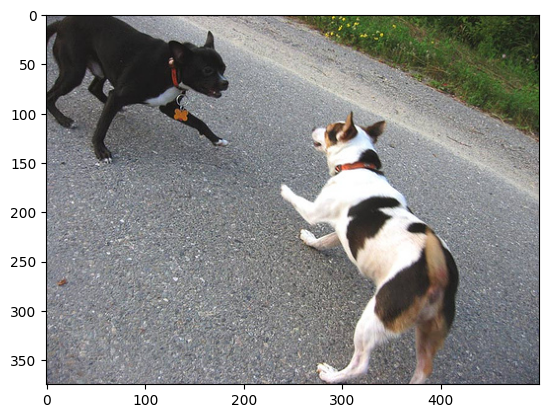

In [44]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
start little girl covered in paint sits in front of painted rainbow with her hands in bowl end
start little girl is sitting in front of large painted rainbow end
start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end
start there is girl with pigtails sitting in front of rainbow painting end
start young girl with pigtails painting outside in the grass end
--------------------Predicted--------------------
start little girl in pigtails is playing with fingerpaints in front of rainbow painted rainbow end


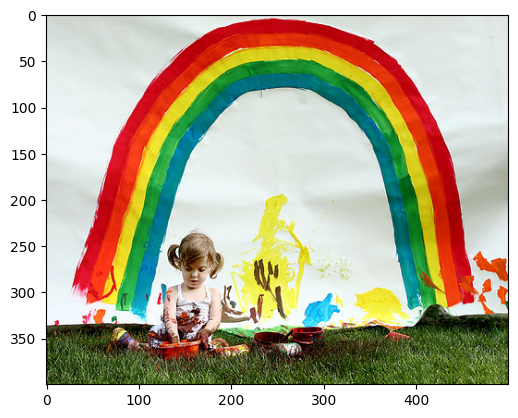

In [45]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
start man in hat is displaying pictures next to skier in blue hat end
start man skis past another man displaying paintings in the snow end
start person wearing skis looking at framed pictures set up in the snow end
start skier looks at framed pictures in the snow next to trees end
start man on skis looking at artwork for sale in the snow end
--------------------Predicted--------------------
start man in black jacket displaying paintings in the snow end


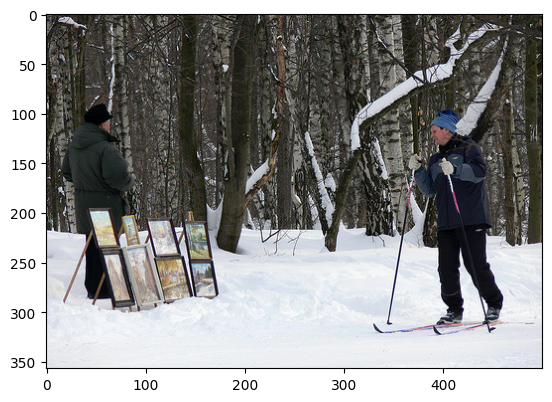

In [46]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [47]:
test

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd',
 '437404867_209625774d',
 '437527058_189f2a7eef',
 '437917001_ae1106f34e',
 '438639005_208bc59b0b',
 '439037721_cdf1fc7358',
 '439049388_3dcee2d30b',
 '439492931_a96d590e40',
 '439569646_c917f1bc78',
 '439916996_1ddb9dc8e7',
 '440184957_267f3f3a2b',
 '440190907_bf8b7ba8ef',
 '440737340_5af34ca9cf',
 '441212506_fcc321ac28',
 '44129946_9eeb385d77',
 '441398149_297146e38d',
 '441817653_fbdf83060b',
 '441921713_1cafc7d7d2',
 '442220883_ff3d6e507f',
 '442594271_2c3dd38483',
 '442918418_0f29c97fa9',
 '443430496_3fea95a07d',
 '443885436_6e927e6c58',
 '444047125_66b249287c',
 '444057017_f1e0fcaef7',
 '444481722_690d0cadcf',
 '444803340_fdcaab86f9',
 '444845904_a4531c811a',
 '444872454_9f51e07f88',
 '444881000_bba92e585c',
 '445148321_9f2f3ac711',
 '445655284_c29e6d7323',
 '445861800_75fc6a8c16',
 '446138054_d40c66d5f0',
 '446286714_dcec7f339e',
 '446291803_2fd4641b99',
 '446514680_ff5ca15ece',
 

---------------------Actual---------------------
start tan curly haired dog jumps in the snow with stick in its mouth end
start white dog catches stick in the snow end
start white dog holds stick in its mouth while it runs through snow end
start white dog jumps in the snow end
start white dog with light brown markings has stick in his mouth and his paws in the snow end
--------------------Predicted--------------------
start dog runs through the snow end


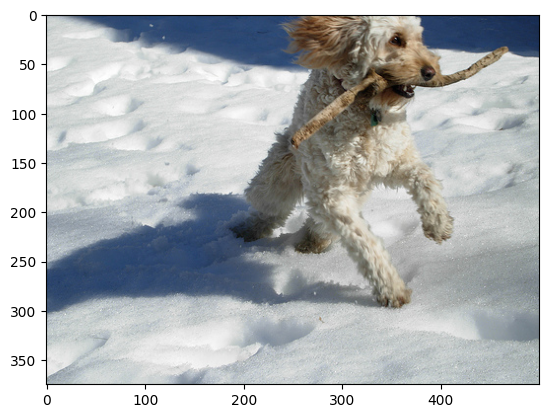

In [48]:
generate_caption("443885436_6e927e6c58.jpg")

---------------------Actual---------------------
start white dog fetches stick as he swims in lake end
start white dog holds stick while swimming end
start white dog retrieves the stick from the lake for her owner end
start white dog swims with stick end
start white dog retrieving stick from water end
--------------------Predicted--------------------
start white dog with collar is walking on the sand end


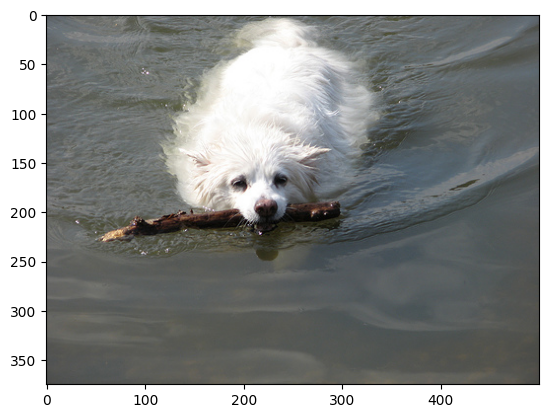

In [49]:
generate_caption("475980315_b8ecd50094.jpg")

---------------------Actual---------------------
start human figure stands on the peak of snowy mountain end
start man is standing on mountaintop looking into the distance end
start man is standing on rocks looking towards the mountains end
start man stands on top of mountain end
start man standing at the top of mountain at dusk end
--------------------Predicted--------------------
start man is standing on the bank of mountain and looks at the view end


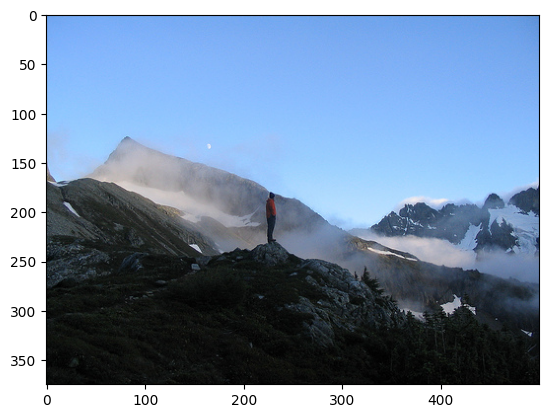

In [50]:
generate_caption("58357057_dea882479e.jpg")